In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import os
import sys
import math
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib import cm, colors
import copy
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.progress import *
%matplotlib inline
palette = sns.color_palette("bright", 10)

In [2]:
n=2000
sampled_df1=pd.read_csv("final_2000.csv")
df_X=sampled_df1.loc[:, sampled_df1.columns.str.contains('X')]

In [3]:
k0=30
k=9
kmeans = KMeans(n_clusters=k0, random_state=0).fit(df_X)

In [4]:
cluster_centers=pd.DataFrame(kmeans.cluster_centers_,columns=df_X.columns, index=["center"+str(i) for i in range(k0)])
frames = [df_X, cluster_centers]
df_X_1 = pd.concat(frames)
dfij=pd.DataFrame(distance_matrix(df_X_1.values, df_X_1.values), index=df_X_1.index, columns=df_X_1.index)
dij=dfij.to_numpy()
dij = np.round(dij, decimals=2)

In [5]:
colors = sns.color_palette()
c1, c2, c3, c4, c5, c6,c7,c8,c9,c10 = colors[0], colors[1], colors[2], colors[3], colors[4], colors[5],colors[6],colors[7],colors[8],colors[9]

In [6]:
def label_transform(x):
    if x in (1, 2, 3):
        return 'H'
    if x in (52, 53, 54):
        return 'L'
    return 'O'

In [7]:
def label_to_color(x):
    if x in (1,2,3):
        return c4
    if x in (52,53,54):
        return c1
    return c5

In [8]:
def label_to_alphas(x):
    if x in (1,2,3):
        return 1
    if x in (52,53,54):
        return 1
    return 0.4

In [36]:
sampled_df1['plot'] = sampled_df1['ACORN_Type'].apply(lambda x:label_transform(x))

In [37]:
H=sampled_df1[sampled_df1['plot']=='H'].index
L=sampled_df1[sampled_df1['plot']=='L'].index
O=sampled_df1[sampled_df1['plot']=='O'].index

In [11]:
def find_most_closed_points(dij,k0):
    N=dij.shape[0]
    min_index=[]
    for i in range(N-k0,N):
        mini_value=math.inf
        for j in range(N-k0):
            if dij[i,j]<mini_value:
                mini_value=dij[i,j]
                mini_index=j
        min_index.append(mini_index)
    return min_index

In [12]:
M=range(len(set(find_most_closed_points(dij,k0))))
N=range(sampled_df1.shape[0])
column1=list(set(find_most_closed_points(dij,k0)))

In [13]:
ddfij=dfij.iloc[0:n,column1]
ddfij=ddfij.to_numpy()
ddfij = np.round(ddfij, decimals=2)

In [20]:
def Benders_Decompisition(name,log_output,N,M,H,L,k,ddfij,strategy,clean_before_solve):
    mdl=Model(name=name,log_output=log_output)
        #set variables
    x=mdl.continuous_var_dict([(i,j) for i in N for j in M],lb=0.0, name="x")
    y=mdl.binary_var_dict([j for j in M],name="y")
    mdl.add_constraints(x[i, j] -y[j]<= 0 for i in N for j in M)
    mdl.add_constraint(mdl.sum(y[j] for j in M) ==k)
    mdl.add_constraints(mdl.sum(x[i, j] for j in M) == 1 for i in N)
    mdl.add_constraints(x[i1, j]+x[i2, j] -1<= 0 for i1 in H for i2 in L for j in M)
    mdl.minimize(mdl.sum(ddfij[i, j]*x[i,j] for i in N for j in M))
    mdl.parameters.benders.strategy = strategy
    sol_model = mdl.solve(clean_before_solve=clean_before_solve)
    return x, y, sol_model

In [22]:
start2=datetime.now()
x, y, sol_model=Benders_Decompisition(name="benders",log_output=True,N=N,M=M,H=H,L=L,k=k,ddfij=ddfij,strategy=3,clean_before_solve=True)
print(datetime.now()-start2)

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Benders_Strategy                        3
Tried aggregator 1 time.
Reduced MIP has 356121 rows, 60030 columns, and 768270 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.34 sec. (246.52 ticks)
Found incumbent of value 1305078.680000 after 0.88 sec. (657.55 ticks)
Tried aggregator 1 time.
Reduced MIP has 356121 rows, 60030 columns, and 768270 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.30 sec. (232.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 0 columns.
Reduced MIP has 2175 rows, 1760 columns, and 5804 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.10 ticks)
Probing time = 0.00 sec. (0.31 ticks)
Cover probing f

In [108]:
def xij_to_label(Xij,N,M):
    labels=[]
    for i in N:
        for j in M:
            if Xij[i,j]>=0.9:
                labels.append(j)
    return labels

In [109]:
#extrac x and y
def extract_solution(x,y,N,M):
    Xij=np.zeros(shape=(len(N),len(M)))
    Yj=np.zeros(shape=(len(M)))
    for i in N:
        for j in M:
            Xij[i,j]=x[(i,j)].solution_value
    labels=xij_to_label(Xij,N,M)
    for j in M:
        Yj[j]=y[j].solution_value
    return labels, Xij, Yj

In [110]:
labels,Xij,Yj=extract_solution(x=x,y=y,N=N,M=M)

In [111]:
len(labels)

2000

In [75]:
pd.DataFrame(labels).T.to_csv("k_means_Benders_2000_9_labels_list.csv")
pd.DataFrame(Xij).to_csv("k_means_Benders_2000_9_Xij.csv")
pd.DataFrame(Yj).T.to_csv("k_means_Benders_2000_9_Yj.csv")

In [113]:
sampled_df2=copy.deepcopy(sampled_df1)
sampled_df2['color'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_color(x))
sampled_df2['plot'] = sampled_df2['ACORN_Type'].apply(lambda x:label_transform(x))
sampled_df2['alphas'] = sampled_df2['ACORN_Type'].apply(lambda x:label_to_alphas(x))
sampled_df2['label']=labels
kmeans_Benders_sampled_df2=sampled_df2.loc[:, sampled_df2.columns.str.contains('X') |sampled_df2.columns.str.contains('label') |sampled_df2.columns.str.contains('ACORN_Type')]
kmeans_Benders_sampled_df2.head()

,X2009.07.24,X2009.07.25,X2009.07.26,X2009.07.27,X2009.07.28,X2009.07.29,X2009.07.30,X2009.07.31,X2009.08.01,X2009.08.02,...,X2009.12.13,X2009.12.14,X2009.12.15,X2009.12.16,X2009.12.17,X2009.12.18,X2009.12.19,X2009.12.20,ACORN_Type,label
0,12.710,14.842,12.926,15.661,11.760,14.954,13.673,16.115,13.931,13.338,...,13.026,12.147,11.972,10.271,14.113,10.563,13.244,14.215,44,4
1,13.000,9.830,12.840,13.590,10.100,13.020,16.450,10.410,16.990,8.690,...,22.190,28.840,27.470,31.080,27.030,29.660,35.020,30.310,5,28
2,4.917,7.580,3.755,5.276,4.290,4.854,4.774,4.190,5.406,6.408,...,5.941,5.293,4.938,4.026,4.654,4.320,4.953,8.196,19,14
3,14.150,11.850,19.620,14.180,11.220,19.550,14.230,9.140,3.070,3.090,...,24.750,33.930,18.050,10.730,19.970,14.760,18.200,19.170,2,28
4,6.034,4.943,4.877,5.264,6.106,6.453,6.313,5.306,5.529,5.670,...,11.832,15.673,11.952,11.061,11.152,11.127,12.099,10.338,1,6


In [114]:
colors=sampled_df2['color']
alphas=sampled_df2['alphas']
plots=sampled_df2['plot']

In [115]:
sampled_df2['label'].value_counts().to_csv('k_means_Benders_2000_9_value_count.csv')
pd.crosstab(kmeans_Benders_sampled_df2['label'],kmeans_Benders_sampled_df2['ACORN_Type']).to_csv('label_ACORN2000_9_k_means_Benders.csv')

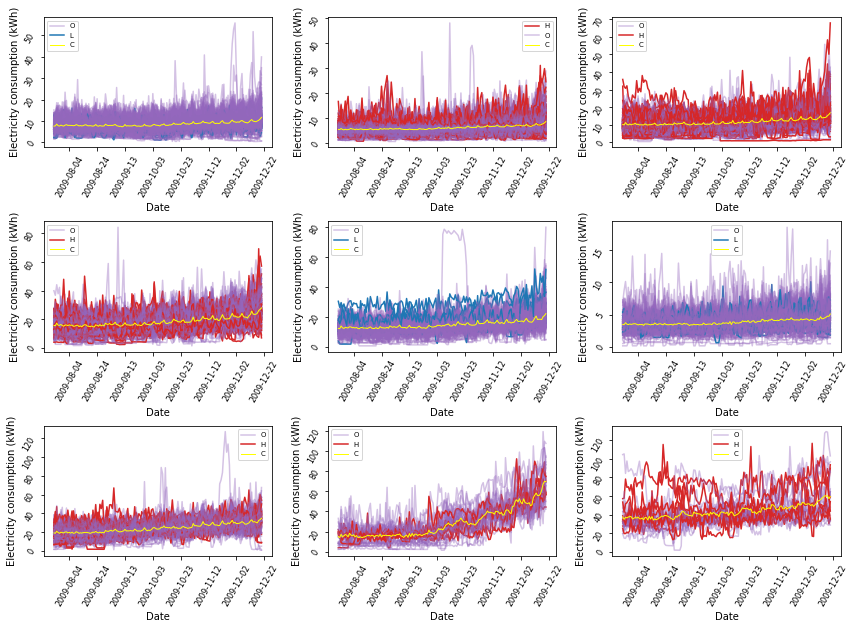

In [116]:
dat_L=kmeans_Benders_sampled_df2
ALL_ACORN_Type=set(kmeans_Benders_sampled_df2['ACORN_Type'].value_counts().values)
plot_labels=kmeans_Benders_sampled_df2['label'].value_counts().index.tolist()
titles=['Pattern 1','Pattern 2','Pattern 3','Pattern 4','Pattern 5','Pattern 6','Pattern 7','Pattern 8','Pattern 9']
y_mean=[]
#fig, ax = plt.subplots(nrows=3, ncols=2)
#fig.set_size_inches(20,15)
#norm = colors.Normalize(vmin=min(ALL_ACORN_Type), vmax=max(ALL_ACORN_Type))
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)

fig = plt.figure()
fig.set_size_inches(12,9)
for c,num in zip(plot_labels, range(1,10)):
    df0=dat_L[dat_L['label']==c]
    df0T=df0.drop('label',axis=1).T
    ACORN_Type=df0T.loc['ACORN_Type',:].values
    df0T=df0T.drop('ACORN_Type',axis=0)
    df0T.index=pd.date_range(start='7/24/2009', end='12/20/2009')
    col=df0T.shape[1]
    df0T['Mean']=df0T.mean(axis=1)
    df0T['Date']=pd.to_datetime(df0T.index,infer_datetime_format=True)
    ax = fig.add_subplot(3,3,num)
    for i in range(col):
        #ax.plot(df0T['Date'], df0T.iloc[:,i],color=mapper.to_rgba(ACORN_Type[i]))
        ax.plot(df0T['Date'], df0T.iloc[:,i],color=colors[df0T.columns[i]],alpha=alphas[df0T.columns[i]],label=plots[df0T.columns[i]])
    ax.plot(df0T['Date'], df0T['Mean'],color='yellow',linewidth=1,label='C')
    y_mean.append(df0T['Mean'].mean())
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #my_y_ticks = np.arange(0, 130, 20)
    #plt.yticks(my_y_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)
    #ax.set_ylim(0,80)
    #ax.set_title(titles[c-1])
    ax.tick_params(labelrotation=60)
    plt.ylabel('Electricity consumption (kWh)')
    plt.xlabel('Date')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),prop={'size': 7})
    #ax.legend(loc = 'best')

# plt.xlabel('Date')
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
#plt.ylabel('Electricity consumption(KWh)')

#fig.suptitle('Residential daily electricity patterns based on Partitioning Around Medoids algorithms (k=5)',fontsize=25)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()